<a href="https://colab.research.google.com/github/yuvalgrossman/EquSolve/blob/master/shahar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
device = get_device()

In [105]:
# get data
!wget 'https://zenodo.org/record/259444/files/HASYv2.tar.bz2?download=1'
my_tar = tarfile.open('HASYv2.tar.bz2?download=1')
my_tar.extractall() # specify which folder to extract to
my_tar.close()
meta_data = pd.read_csv('hasy-data-labels.csv')


--2020-08-16 16:03:11--  https://zenodo.org/record/259444/files/HASYv2.tar.bz2?download=1
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34597561 (33M) [application/octet-stream]
Saving to: ‘HASYv2.tar.bz2?download=1.2’

HASYv2.tar.bz2?down 100%[===================>]  32.99M  61.4MB/s    in 0.5s    

2020-08-16 16:03:12 (61.4 MB/s) - ‘HASYv2.tar.bz2?download=1.2’ saved [34597561/34597561]



img shape =  (32, 32, 3)


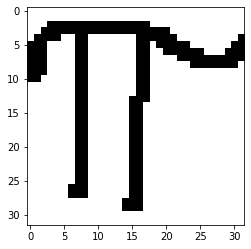

In [106]:
# show example
img = plt.imread(meta_data['path'][603])
plt.imshow(img)
print('img shape = ',img.shape)

In [107]:
# start with data subset
train_df = pd.read_csv('classification-task/fold-1/train.csv')
test_df = pd.read_csv('classification-task/fold-1/test.csv')
train_df.head()

,path,symbol_id,latex,user_id
0,../../hasy-data/v2-00016.png,31,A,8071
1,../../hasy-data/v2-00017.png,31,A,9505
2,../../hasy-data/v2-00018.png,31,A,16925
3,../../hasy-data/v2-00019.png,31,A,16925
4,../../hasy-data/v2-00020.png,31,A,16925


In [108]:

class ExampleDataset(Dataset):
    def __init__(self,csv_df,transforms=None):
      self.data = csv_df
      self.transforms = transforms

    def __len__(self):
        
        return len(self.data.index)
    
    def __getitem__(self, idx):
        y = self.data.loc[idx, 'symbol_id']
        X = plt.imread(self.data.loc[idx,'path'][6:])

        if self.transforms:
            X = self.transforms(X)

        return (X,y)

In [109]:
train_data = ExampleDataset(train_df)
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)


In [110]:
# define the neural net class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, 
                               kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, 
                               kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=10)
 
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)
print(net)
# loss
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [111]:
def train(net, trainloader):
    for epoch in range(1): # no. of epochs
        running_loss = 0
        for data in trainloader:
            # data pixels and labels to GPU if available
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            # set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # propagate the loss backward
            loss.backward()
            # update the gradients
            optimizer.step()
 
            running_loss += loss.item()
        print('[Epoch %d] loss: %.3f' %
                      (epoch + 1, running_loss/len(trainloader)))
 
    print('Done Training')
 
def test(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
 
    print('Accuracy of the network on test images: %0.3f %%' % (
        100 * correct / total))
    
train(net, trainloader)
test(net, testloader)

RuntimeError: ignored

In [ ]:
p = '../../hasy-data/v2-148446.png'
img = plt.imread(p[6:])


In [ ]:
!ls